In [1]:
from transformers import pipeline, AutoTokenizer
from datasets import Dataset

twitter = "cardiffnlp/twitter-roberta-base-sentiment-latest"
financial = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

classifierConfig = dict(
    task = "text-classification",
    model = twitter,
    device = "cuda",
    truncation = True,
    max_length = 512,
    return_all_scores = True
)

summarizerConfig = dict(
    task = "summarization",
    model = "facebook/bart-large-cnn",
    device = "cuda",
    do_sample = True,
    truncation = False,
    num_beams = 2,
    num_return_sequences = 1
)

classifier = pipeline(**classifierConfig)
tokenizerClassifier =AutoTokenizer.from_pretrained(twitter, device="cuda")
summarizer = pipeline(**summarizerConfig)

c:\Users\zizh3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a mode

In [2]:
import requests
import json
import datetime


with open("credential", "r") as f:
    jsonStr = f.read()
    creds = json.loads(jsonStr)


def fetchNews(start:datetime.datetime, end:datetime.datetime, symbols:str, limit:int=20, include_content:bool=True, exclude_contentless:bool=True):
    newsList = []
    startStr = start.strftime("%Y-%m-%dT%H:%M:%SZ")
    endStr = end.strftime("%Y-%m-%dT%H:%M:%SZ")
    url = f"https://data.alpaca.markets/v1beta1/news?start={startStr}&end={endStr}&sort=desc&symbols={symbols}&limit={limit}&include_content={include_content}&exclude_contentless={exclude_contentless}"
    headers = {"accept": "application/json", "APCA-API-KEY-ID": creds["alpacaPaper"][0], "APCA-API-SECRET-KEY": creds["alpacaPaper"][1]}

    resp = requests.get(url, headers=headers)
    if resp.status_code != 200:
        raise Exception(f"Failed to fetch news: {resp.status_code} {resp.text}")
    data = resp.json()
    news = data.get("news", [])
    newsList.extend(news)
    next_page_token = data.get("next_page_token", None)
    while next_page_token:
        url = f"https://data.alpaca.markets/v1beta1/news?start={startStr}&end={endStr}&sort=desc&symbols={symbols}&limit={limit}&include_content={include_content}&exclude_contentless={exclude_contentless}&page_token={next_page_token}"
        resp = requests.get(url, headers=headers)
        if resp.status_code != 200:
            raise Exception(f"Failed to fetch news: {resp.status_code} {resp.text}")
        data = resp.json()
        news = data.get("news", [])
        newsList.extend(news)
        next_page_token = data.get("next_page_token", None)
    return newsList


news = fetchNews(datetime.datetime.now()-datetime.timedelta(days=7), datetime.datetime.now(), "NVDA", 50, True, True)  
len(news)

82

In [3]:
news[0]

{'author': 'Benzinga Insights',
 'content': '<p>This whale alert can help traders discover the next big trading opportunities.</p>\n<p>Whales are entities with large sums of money and we track their transactions here at Benzinga on our options activity scanner.</p>\n<p>Traders will search for circumstances when the market estimation of an option diverges heavily from its normal worth. High amounts of trading activity could push option prices to exaggerated or underestimated levels. </p>\n<p>Below are some instances of options activity happening in the Information Technology sector:  <table>\n<thead>\n<tr>\n<th><strong>Symbol</strong></th>\n<th><strong>PUT/CALL</strong></th>\n<th><strong>Trade Type</strong></th>\n<th><strong>Sentiment</strong></th>\n<th><strong>Exp. Date</strong></th>\n<th><strong>Strike Price</strong></th>\n<th><strong>Total Trade Price</strong></th>\n<th><strong>Open Interest</strong></th>\n<th><strong>Volume</strong></th>\n</tr>\n</thead>\n<tbody>\n<tr>\n<td>NVDA</td

In [4]:
len(tokenizerClassifier(news[0]["content"])["input_ids"]), len(tokenizerClassifier(news[1]["content"])["input_ids"]), len(tokenizerClassifier(news[2]["content"])["input_ids"])

(3750, 815, 1204)

In [5]:
summarizer(news[1]["content"])

[{'summary_text': 'Psychedelic drugs, such as psilocybin mushrooms and LSD, were once seen merely as a way for college students and concert goers to escape reality or at least enhance it. Now, these drugs are being heavily considered by doctors throughout the world. Atai Life Sciences is a pre-clinical biotech company focused on treating mental illnesses using psychedelic drugs.'}]

In [ ]:
import regex as re
import numpy as np  

htmlElement = re.compile(r"<.*?>")
def preprocessTexts(text):
    # remove html elements
    processed = re.sub(htmlElement, "", text)
    # remove special chars
    processed = re.sub(r"\s+|&#[0-9]+;|&nbsp;", " ", processed)
    processed = re.sub(r"&amp;", "&", processed)
    return processed

labelArr = ["negative", "neutral", "positive"]
def getLabel(score):
    scores = np.array([score[0]["score"], score[1]["score"], score[2]["score"]])
    return labelArr[np.argmax(scores)]

contentDataset = Dataset.from_dict(dict(
    inputs = [preprocessTexts(n["content"]) for n in news] 
))

summaryDataset = Dataset.from_dict(dict(
    inputs = [preprocessTexts(n["summary"]) for n in news]
))

arrContentEmoScore = classifier(contentDataset["inputs"])
arrSummaryEmoScore = classifier(summaryDataset["inputs"])
arrSummaries = summarizer(contentDataset["inputs"])

modelSummaryDataset = Dataset.from_dict(dict(
    inputs = [s["summary_text"] for s in arrSummaries]
))
arrModelSummaryEmoScore = classifier(modelSummaryDataset["inputs"])

# processedNews = [{
#     "id": n["id"],
#     "time": n["created_at"],
#     "source": n["source"],
#     "symbols": ",".join(n["symbols"]),
#     "relative_weight": 1/len(n["symbols"]),
#     "title": n["headline"],
#     "content": preprocessTexts(n["content"]),
#     "summary":preprocessTexts(n["summary"]) if len(n["summary"].strip()) > 0 else None,
#     "modelSummary": summ["summary_text"],
#     "label-summ": getLabel(summEmo),
#     "negative-summ": summEmo[0]["score"],
#     "neutral-summ": summEmo[1]["score"],
#     "positive-summ": summEmo[2]["score"],

#     "label-content": getLabel(contentEmo),
#     "negative-content": contentEmo[0]["score"],
#     "neutral-content": contentEmo[1]["score"],
#     "positive-content": contentEmo[2]["score"],

#     "label-model-summ": getLabel(mdSummEmo),
#     "negative-model-summ": mdSummEmo[0]["score"],
#     "neutral-model-summ": mdSummEmo[1]["score"],
#     "positive-model-summ": mdSummEmo[2]["score"],
# } for n, summ, summEmo, contentEmo, mdSummEmo in zip(news, arrSummaries, arrSummaryEmoScore, arrContentEmoScore, arrModelSummaryEmoScore)]


processedNews = [{
    "id": n["id"],
    "time": n["created_at"],
    "source": n["source"],
    "symbols": ",".join(n["symbols"]),
    "relative_weight": 1/len(n["symbols"]),
    "title": n["headline"],
    "content": preprocessTexts(n["content"]),
    "summary":preprocessTexts(n["summary"]) if len(n["summary"].strip()) > 0 else None,
    "modelSummary": summ["summary_text"],
    "label": getLabel(summEmo),
    "negative": summEmo[0]["score"],
    "neutral": summEmo[1]["score"],
    "positive": summEmo[2]["score"],
} for n, summ, summEmo in zip(news, arrSummaries, arrSummaryEmoScore)]

Text(0.5, 1.0, 'content length')

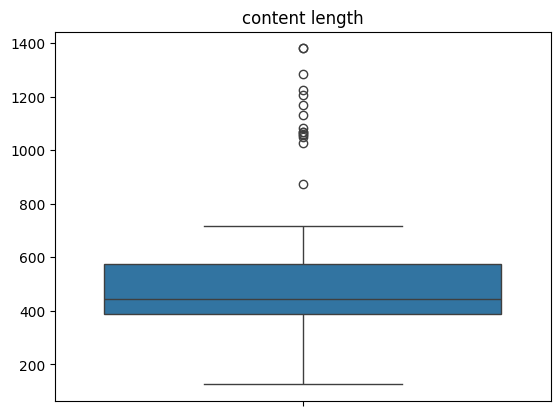

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


tokenLength = [len(n["content"].split()) for n in processedNews]
sns.boxplot(tokenLength).set_title("content length")

In [6]:
df = pd.DataFrame(processedNews)
df.head()

,id,time,source,symbols,relative_weight,title,content,summary,modelSummary,label-summ,...,neutral-summ,positive-summ,label-content,negative-content,neutral-content,positive-content,label-model-summ,negative-model-summ,neutral-model-summ,positive-model-summ
0,37670631,2024-03-13T17:35:17Z,benzinga,"[AI, AMD, CORZ, INTC, MARA, NVDA, PANW, SMCI, ...",0.100000,10 Information Technology Stocks With Whale Al...,This whale alert can help traders discover the...,None,Whales are entities with large sums of money a...,neutral,...,0.670370,0.270926,neutral,0.009944,0.666299,0.323757,neutral,0.121070,0.847054,0.031876
1,23838896,2021-11-02T20:43:25Z,benzinga,"[ATAI, GME, NVDA, TSLA]",0.250000,This Psychedelics Stock Was Up More Than 20% L...,Psychedelics have picked up more and more mome...,Psychedelics have picked up more and more mome...,Atai Life Sciences is a pre-clinical biotech c...,positive,...,0.137827,0.859917,positive,0.005149,0.195005,0.799846,neutral,0.027130,0.812949,0.159920
2,37650865,2024-03-13T17:18:05Z,benzinga,"[ADIV, AGOV, ASHR, BBEU, BOIL, CQQQ, DBC, EEM,...",0.029412,"Asia Markets Down, Europe Rises While Crude Ad...",Editor note: The headline of this story has be...,None,The S ;P 500 closed at a record high on Tuesda...,neutral,...,0.670370,0.270926,neutral,0.016889,0.659207,0.323905,neutral,0.024606,0.561226,0.414168
3,37662430,2024-03-13T16:21:15Z,benzinga,"[AMD, INTC, NVDA, SMCI]",0.250000,AI Tailwinds Boost Super Micro Computer Analys...,Shares of Super Micro Computer Inc (NASDAQ:SMC...,Shares of Super Micro Computer Inc (NASDAQ: SM...,Super Micro Computer (NASDAQ:SMCI) has rallied...,positive,...,0.062146,0.935662,positive,0.003985,0.128980,0.867035,positive,0.002100,0.033885,0.964015
4,37666432,2024-03-13T15:44:23Z,benzinga,"[AAPL, AMZN, BTCUSD, GLD, GOOG, META, MSFT, NV...",0.071429,Nvidia And Gamma Squeeze Overpower Hotter Infl...,"To gain an edge, this is what you need to know...","To gain an edge, this is what you need to know...",QQQ ran up in spite of hotter inflation data. ...,neutral,...,0.594776,0.393207,neutral,0.012480,0.699092,0.288428,positive,0.008570,0.184261,0.807170


<Axes: >

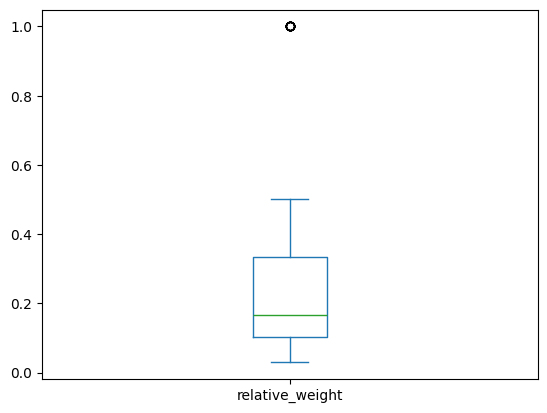

In [8]:
df.relative_weight.plot.box()

In [9]:
import datetime
df.to_csv(f"news-{datetime.datetime.now().timestamp()}.csv", index=False)

<Axes: >

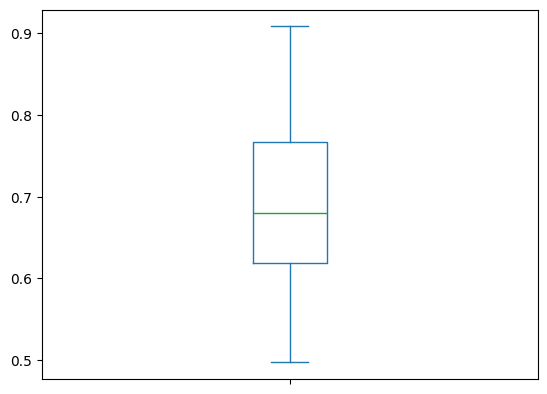

In [7]:
df[["negative-content", "neutral-content", "positive-content"]].apply(max, axis=1).plot.box()

financial classifier stats:
- overall AR = 0.48
- summs AR = 0.58
- summ-content AR = 0.63
- model-summ-content AR= 0.69
- max score dist: lower 25th quantile >= 0.95 skewed

twitter classifier stats:
- overall AR = 0.46
- summs AR = 0.58
- summ-content AR = 0.71
- model-summ-content AR= 0.60
- max score dist: 0.5~0.9 normal
- no negative prediction on content

In [18]:
ar = df.index.map(lambda i: df.loc[i, "label-summ"] == df.loc[i, "label-model-summ"] == df.loc[i, "label-content"]).to_series().mean()
summsAR = df.index.map(lambda i: df.loc[i, "label-summ"] == df.loc[i, "label-model-summ"]).to_series().mean()
summContentAr = df.index.map(lambda i: df.loc[i, "label-summ"] == df.loc[i, "label-content"]).to_series().mean()
modelSummContentAr = df.index.map(lambda i: df.loc[i, "label-model-summ"] == df.loc[i, "label-content"]).to_series().mean()
ar, summsAR, summContentAr, modelSummContentAr

(0.4634146341463415,
 0.5853658536585366,
 0.7195121951219512,
 0.6097560975609756)

Check majority class

In [15]:
df[["negative-model-summ","neutral-model-summ","positive-model-summ",]].apply(np.argmax, axis=1).value_counts()

2    40
1    35
0     7
Name: count, dtype: int64

In [16]:
df[["negative-summ","neutral-summ","positive-summ",]].apply(np.argmax, axis=1).value_counts()

1    42
2    35
0     5
Name: count, dtype: int64

In [17]:
df[["negative-content","neutral-content","positive-content",]].apply(np.argmax, axis=1).value_counts()

1    53
2    29
Name: count, dtype: int64